In [76]:
import torch
import os

# Configurar dispositivo como variable global
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def check_and_clear_gpu():
    # Set up the device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Check GPU availability
    print("GPU available:", torch.cuda.is_available())
    if torch.cuda.is_available():
        print("GPU name:", torch.cuda.get_device_name(0))

    # Reset GPU 
    os.system('nvidia-smi --gpu-reset -i 0')

    # Eliminar sesión activa para liberar recursos
    tf.keras.backend.clear_session()

    # Limpiar la caché de memoria de la GPU
    from tensorflow.python.framework import ops
    ops.reset_default_graph()

    # Vaciar la caché de memoria de CUDA
    torch.cuda.empty_cache()

    # Liberar la memoria reservada por PyTorch
    allocated_memory = torch.cuda.memory_allocated()
    cached_memory = torch.cuda.memory_reserved()

    print("Memoria de GPU liberada con PyTorch")

    # Imprimir el uso de memoria antes y después de liberarlo
    print(f"Allocated GPU Memory: {allocated_memory / 1024 ** 2:.2f} MB")
    print(f"Cached GPU Memory: {cached_memory / 1024 ** 2:.2f} MB")



In [77]:
import bz2
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import numpy as np
from datasets import Dataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from transformers import Trainer, TrainingArguments, TrainerCallback
import matplotlib.pyplot as plt
from transformers import TrainingArguments, Trainer, TrainerCallback
from sklearn.metrics import roc_curve, auc, accuracy_score
from transformers import DistilBertForSequenceClassification



In [78]:
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)


In [80]:
# Define the file paths 
file_path_train = r"C:\Users\Lucas\Desktop\Analisis de sentimientos\Data\Train\train.ft.txt.bz2"
file_path_test = r"C:\Users\Lucas\Desktop\Analisis de sentimientos\Data\Test\test.ft.txt.bz2"



In [81]:
# Function to load data
def load_amazon_reviews(file_path):
    reviews = []
    labels = []

    with bz2.open(file_path, 'rt', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split(' ', 1)
            label = 1 if parts[0] == '__label__2' else 0
            text = parts[1]

            labels.append(label)
            reviews.append(text)

    return pd.DataFrame({
        'text': reviews,
        'sentiment': labels
    })

# Load the data
print("Loading training data...")
df_train = load_amazon_reviews(file_path_train)

print("Loading test data...")
df_test = load_amazon_reviews(file_path_test)

# Verify class balance
print("\nClass balance in training data:")
print(df_train['sentiment'].value_counts())
print("\nPercentage:")
print(df_train['sentiment'].value_counts(normalize=True) * 100)

print("\nClass balance in test data:")
print(df_test['sentiment'].value_counts())
print("\nPercentage:")
print(df_test['sentiment'].value_counts(normalize=True) * 100)


Loading training data...
Loading test data...

Class balance in training data:
sentiment
1    1800000
0    1800000
Name: count, dtype: int64

Percentage:
sentiment
1    50.0
0    50.0
Name: proportion, dtype: float64

Class balance in test data:
sentiment
1    200000
0    200000
Name: count, dtype: int64

Percentage:
sentiment
1    50.0
0    50.0
Name: proportion, dtype: float64


In [82]:
# Define sample size
n_train = 50000
n_test = 10000
"""
# Stratified sampling to maintain balance
df_train_small = pd.concat([ 
    df_train[df_train['sentiment'] == 1].sample(n_train//2, random_state=42), 
    df_train[df_train['sentiment'] == 0].sample(n_train//2, random_state=42) 
]).sample(frac=1, random_state=42)  # Shuffle the samples

df_test_small = pd.concat([ 
    df_test[df_test['sentiment'] == 1].sample(n_test//2, random_state=42), 
    df_test[df_test['sentiment'] == 0].sample(n_test//2, random_state=42) 
]).sample(frac=1, random_state=42)  # Shuffle the samples
"""
# Stratified sampling
df_train_small = pd.concat([df_train[df_train['sentiment'] == 1].sample(n_train//2, random_state=42),
                            df_train[df_train['sentiment'] == 0].sample(n_train//2, random_state=42)]).sample(frac=1, random_state=42)

df_test_small = pd.concat([df_test[df_test['sentiment'] == 1].sample(n_test//2, random_state=42),
                           df_test[df_test['sentiment'] == 0].sample(n_test//2, random_state=42)]).sample(frac=1, random_state=42)

# Convert to Hugging Face Dataset
train_data = Dataset.from_pandas(df_train_small.rename(columns={"sentiment": "labels"}))
test_data = Dataset.from_pandas(df_test_small.rename(columns={"sentiment": "labels"}))

# Verify the new sizes
print("New training set:", df_train_small.shape)
print("New test set:", df_test_small.shape)

# Verify balance is maintained
print("\nBalance in new training set:")
print(df_train_small['sentiment'].value_counts(normalize=True) * 100)

print("\nBalance in new test set:")
print(df_test_small['sentiment'].value_counts(normalize=True) * 100)

New training set: (50000, 2)
New test set: (10000, 2)

Balance in new training set:
sentiment
0    50.0
1    50.0
Name: proportion, dtype: float64

Balance in new test set:
sentiment
0    50.0
1    50.0
Name: proportion, dtype: float64


In [83]:
# Quick data check
print("First examples from train_data:", train_data[:2])
print("First examples from test_data:", test_data[:2])

First examples from train_data: {'text': ['not that good: the product does not have the bad taste it says it does. once applied all it is, is a shiny clear coat on your nails. bite them, there is a hint of a weird taste, but a true nail biter will ignore it. buy something stronger', "Absolute Fiction - A blonde in Harvard Law ...: Just Kidding! But that is the whole premise of the film, right? And yet it isn't offensive and it has a cute moral message of becoming the best that we can be. Reese Witherspoon does a great job as a beautiful blonde who has never been expected to do anything more with her life than look beautiful, who then surprises everyone around her (including herself) by going to law school and suceeding. Even though she goes to law school solely to get back her dumb social climbing boyfriend, in the end she recognizes her own worth and not only betters herself but also manages to nab a great new boyfriend (played by the ever adorable Luke Wilson). So it is truly fiction

In [84]:
df_train_small.head()

,text,sentiment
794992,not that good: the product does not have the b...,0
1084576,Absolute Fiction - A blonde in Harvard Law ......,1
574442,good review: Good to review HY facts after exa...,1
271474,brilliant: this album is wonderful! they've qu...,1
2800233,Careful! Don't order the wrong set: I had want...,0


In [85]:
# Preprocessing function for text data
def preprocess_function(examples):
    return tokenizer(
        examples['text'],                
        truncation=True,                 
        padding="max_length",            
        max_length=128                   
    )

In [86]:
# Tokenize and prepare the data for the model with Hugging Face `Dataset`
train_data = train_data.map(preprocess_function, batched=True, load_from_cache_file=False)
test_data = test_data.map(preprocess_function, batched=True, load_from_cache_file=False)

Map: 100%|██████████| 10000/10000 [00:00<00:00, 14248.46 examples/s]


In [87]:
# View the first 2 examples of train_data after tokenization
print("First examples from train_data (tokenized):")
print(train_data[:2])  # The tokenized data

# View the first 2 examples of test_data after tokenization
print("\nFirst examples from test_data (tokenized):")
print(test_data[:2])  # The tokenized data

First examples from train_data (tokenized):
{'text': ['not that good: the product does not have the bad taste it says it does. once applied all it is, is a shiny clear coat on your nails. bite them, there is a hint of a weird taste, but a true nail biter will ignore it. buy something stronger', "Absolute Fiction - A blonde in Harvard Law ...: Just Kidding! But that is the whole premise of the film, right? And yet it isn't offensive and it has a cute moral message of becoming the best that we can be. Reese Witherspoon does a great job as a beautiful blonde who has never been expected to do anything more with her life than look beautiful, who then surprises everyone around her (including herself) by going to law school and suceeding. Even though she goes to law school solely to get back her dumb social climbing boyfriend, in the end she recognizes her own worth and not only betters herself but also manages to nab a great new boyfriend (played by the ever adorable Luke Wilson). So it is t

In [88]:
# Set up training arguments
training_args = TrainingArguments(
    output_dir="C:/Users/Lucas/Desktop/Analisis de sentimientos/Models/checkpoint-01",  # Directory to save model checkpoints
    evaluation_strategy="steps",         # Evaluate every few steps
    eval_steps=500,                      # Evaluate every 500 steps
    per_device_train_batch_size=64,      # Batch size for training
    per_device_eval_batch_size=64,       # Batch size for evaluation
    num_train_epochs=6,                  # Number of training epochs
    weight_decay=0.01,                   # Weight decay for regularization
    learning_rate=4e-5,                  # Learning rate
    logging_dir="./logs",                # Directory for logging
    logging_steps=50,                    # Log every 50 steps
    warmup_steps=500,                    # Number of warm-up steps for learning rate
    lr_scheduler_type='linear',          # Linear learning rate scheduler
    fp16=True                            # Enable mixed precision (16-bit)
)

c:\Users\Lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
def compute_metrics(p):
    """
    Computes evaluation metrics.
    Args:
        p: Evaluation predictions and labels.
    Returns:
        dict: Dictionary containing accuracy as a metric.
    """
    preds = p.predictions.argmax(axis=-1)  
    labels = p.label_ids                   
    return {"accuracy": accuracy_score(labels, preds)}  # Return the accuracy metric as a dictionary

In [91]:
# Custom callback to log metrics during training and evaluation
class MetricsLogger(TrainerCallback):
    """
    Custom callback to log metrics during training and evaluation.
    """
    def __init__(self):
        self.logs = []  

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            self.logs.append(logs)  

In [92]:
# Create trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=test_data,
    compute_metrics=compute_metrics
)

In [93]:
# Train Model
print("\nTraining the model...")
trainer.train()


Training the model...


  1%|          | 50/4692 [01:09<1:47:41,  1.39s/it]

{'loss': 0.4354, 'grad_norm': 7.981222152709961, 'learning_rate': 3.920000000000001e-06, 'epoch': 0.06}


  2%|▏         | 100/4692 [02:21<1:49:05,  1.43s/it]

{'loss': 0.2433, 'grad_norm': 3.1493208408355713, 'learning_rate': 7.92e-06, 'epoch': 0.13}


  3%|▎         | 150/4692 [03:31<1:48:44,  1.44s/it]

{'loss': 0.233, 'grad_norm': 3.0632436275482178, 'learning_rate': 1.1920000000000001e-05, 'epoch': 0.19}


  4%|▍         | 200/4692 [04:44<1:51:21,  1.49s/it]

{'loss': 0.2093, 'grad_norm': 2.735607385635376, 'learning_rate': 1.5920000000000003e-05, 'epoch': 0.26}


  5%|▌         | 250/4692 [05:57<1:45:41,  1.43s/it]

{'loss': 0.21, 'grad_norm': 4.633025646209717, 'learning_rate': 1.9920000000000002e-05, 'epoch': 0.32}


  6%|▋         | 300/4692 [07:09<1:48:24,  1.48s/it]

{'loss': 0.1856, 'grad_norm': 2.8487131595611572, 'learning_rate': 2.392e-05, 'epoch': 0.38}


  7%|▋         | 350/4692 [08:19<1:43:18,  1.43s/it]

{'loss': 0.1969, 'grad_norm': 2.8210623264312744, 'learning_rate': 2.792e-05, 'epoch': 0.45}


  9%|▊         | 400/4692 [09:30<1:41:19,  1.42s/it]

{'loss': 0.1769, 'grad_norm': 2.7786436080932617, 'learning_rate': 3.1920000000000006e-05, 'epoch': 0.51}


 10%|▉         | 450/4692 [10:40<1:40:16,  1.42s/it]

{'loss': 0.2008, 'grad_norm': 2.1340110301971436, 'learning_rate': 3.592e-05, 'epoch': 0.58}


 11%|█         | 500/4692 [11:52<1:39:15,  1.42s/it]

{'loss': 0.1946, 'grad_norm': 2.7316269874572754, 'learning_rate': 3.9920000000000004e-05, 'epoch': 0.64}


                                                    
 11%|█         | 500/4692 [12:07<1:39:15,  1.42s/it]

{'eval_loss': 0.17185990512371063, 'eval_accuracy': 0.9322, 'eval_runtime': 15.8937, 'eval_samples_per_second': 629.179, 'eval_steps_per_second': 9.878, 'epoch': 0.64}


 12%|█▏        | 550/4692 [13:19<1:36:59,  1.40s/it]

{'loss': 0.1771, 'grad_norm': 3.1681272983551025, 'learning_rate': 3.953244274809161e-05, 'epoch': 0.7}


 13%|█▎        | 600/4692 [14:30<1:35:51,  1.41s/it]

{'loss': 0.189, 'grad_norm': 1.2966947555541992, 'learning_rate': 3.905534351145038e-05, 'epoch': 0.77}


 14%|█▍        | 650/4692 [15:40<1:35:11,  1.41s/it]

{'loss': 0.177, 'grad_norm': 2.310584783554077, 'learning_rate': 3.8578244274809163e-05, 'epoch': 0.83}


 15%|█▍        | 700/4692 [16:53<1:39:06,  1.49s/it]

{'loss': 0.1669, 'grad_norm': 2.6895487308502197, 'learning_rate': 3.8101145038167945e-05, 'epoch': 0.9}


 16%|█▌        | 750/4692 [18:03<1:32:13,  1.40s/it]

{'loss': 0.1616, 'grad_norm': 2.157391309738159, 'learning_rate': 3.762404580152672e-05, 'epoch': 0.96}


 17%|█▋        | 800/4692 [19:13<1:32:30,  1.43s/it]

{'loss': 0.1348, 'grad_norm': 2.0266425609588623, 'learning_rate': 3.71469465648855e-05, 'epoch': 1.02}


 18%|█▊        | 850/4692 [20:25<1:30:12,  1.41s/it]

{'loss': 0.1232, 'grad_norm': 2.2961745262145996, 'learning_rate': 3.666984732824428e-05, 'epoch': 1.09}


 19%|█▉        | 900/4692 [21:35<1:31:29,  1.45s/it]

{'loss': 0.1143, 'grad_norm': 2.5198988914489746, 'learning_rate': 3.619274809160306e-05, 'epoch': 1.15}


 20%|██        | 950/4692 [22:47<1:27:32,  1.40s/it]

{'loss': 0.1163, 'grad_norm': 2.0650572776794434, 'learning_rate': 3.571564885496183e-05, 'epoch': 1.21}


 21%|██▏       | 1000/4692 [23:59<1:26:51,  1.41s/it]

{'loss': 0.1171, 'grad_norm': 0.8744985461235046, 'learning_rate': 3.523854961832061e-05, 'epoch': 1.28}


                                                     
 21%|██▏       | 1000/4692 [24:15<1:26:51,  1.41s/it]

{'eval_loss': 0.16111893951892853, 'eval_accuracy': 0.9421, 'eval_runtime': 15.9756, 'eval_samples_per_second': 625.956, 'eval_steps_per_second': 9.828, 'epoch': 1.28}


 22%|██▏       | 1050/4692 [25:29<1:25:44,  1.41s/it]

{'loss': 0.1266, 'grad_norm': 1.16811203956604, 'learning_rate': 3.4761450381679394e-05, 'epoch': 1.34}


 23%|██▎       | 1100/4692 [26:39<1:23:56,  1.40s/it]

{'loss': 0.1273, 'grad_norm': 2.7061216831207275, 'learning_rate': 3.4284351145038176e-05, 'epoch': 1.41}


 25%|██▍       | 1150/4692 [27:51<1:23:05,  1.41s/it]

{'loss': 0.1192, 'grad_norm': 2.219409227371216, 'learning_rate': 3.380725190839695e-05, 'epoch': 1.47}


 26%|██▌       | 1200/4692 [29:02<1:21:48,  1.41s/it]

{'loss': 0.1165, 'grad_norm': 1.6716927289962769, 'learning_rate': 3.3330152671755725e-05, 'epoch': 1.53}


 27%|██▋       | 1250/4692 [30:14<1:20:52,  1.41s/it]

{'loss': 0.1145, 'grad_norm': 2.7574350833892822, 'learning_rate': 3.2853053435114506e-05, 'epoch': 1.6}


 28%|██▊       | 1300/4692 [31:24<1:19:29,  1.41s/it]

{'loss': 0.1357, 'grad_norm': 3.93041729927063, 'learning_rate': 3.237595419847329e-05, 'epoch': 1.66}


 29%|██▉       | 1350/4692 [32:37<1:23:02,  1.49s/it]

{'loss': 0.1183, 'grad_norm': 1.7509344816207886, 'learning_rate': 3.189885496183206e-05, 'epoch': 1.73}


 30%|██▉       | 1400/4692 [33:48<1:16:54,  1.40s/it]

{'loss': 0.1178, 'grad_norm': 0.5338672399520874, 'learning_rate': 3.1421755725190844e-05, 'epoch': 1.79}


 31%|███       | 1450/4692 [34:59<1:15:58,  1.41s/it]

{'loss': 0.1084, 'grad_norm': 2.0843043327331543, 'learning_rate': 3.094465648854962e-05, 'epoch': 1.85}


 32%|███▏      | 1500/4692 [36:09<1:14:38,  1.40s/it]

{'loss': 0.1029, 'grad_norm': 2.0289905071258545, 'learning_rate': 3.0467557251908397e-05, 'epoch': 1.92}


                                                     
 32%|███▏      | 1500/4692 [36:25<1:14:38,  1.40s/it]

{'eval_loss': 0.16890475153923035, 'eval_accuracy': 0.9416, 'eval_runtime': 15.9356, 'eval_samples_per_second': 627.527, 'eval_steps_per_second': 9.852, 'epoch': 1.92}


 33%|███▎      | 1550/4692 [37:37<1:13:20,  1.40s/it]

{'loss': 0.1083, 'grad_norm': 1.0151921510696411, 'learning_rate': 2.9990458015267178e-05, 'epoch': 1.98}


 34%|███▍      | 1600/4692 [38:46<1:12:19,  1.40s/it]

{'loss': 0.0842, 'grad_norm': 3.509106397628784, 'learning_rate': 2.9513358778625956e-05, 'epoch': 2.05}


 35%|███▌      | 1650/4692 [39:56<1:11:30,  1.41s/it]

{'loss': 0.0608, 'grad_norm': 4.455018520355225, 'learning_rate': 2.9036259541984737e-05, 'epoch': 2.11}


 36%|███▌      | 1700/4692 [41:07<1:09:56,  1.40s/it]

{'loss': 0.0487, 'grad_norm': 5.2104082107543945, 'learning_rate': 2.8559160305343515e-05, 'epoch': 2.17}


 37%|███▋      | 1750/4692 [42:17<1:08:47,  1.40s/it]

{'loss': 0.0584, 'grad_norm': 2.7924294471740723, 'learning_rate': 2.808206106870229e-05, 'epoch': 2.24}


 38%|███▊      | 1800/4692 [43:27<1:07:54,  1.41s/it]

{'loss': 0.0667, 'grad_norm': 2.072479724884033, 'learning_rate': 2.760496183206107e-05, 'epoch': 2.3}


 39%|███▉      | 1850/4692 [44:38<1:06:28,  1.40s/it]

{'loss': 0.0698, 'grad_norm': 0.9945819973945618, 'learning_rate': 2.712786259541985e-05, 'epoch': 2.37}


 40%|████      | 1900/4692 [45:48<1:05:10,  1.40s/it]

{'loss': 0.0635, 'grad_norm': 6.507192134857178, 'learning_rate': 2.6650763358778628e-05, 'epoch': 2.43}


 42%|████▏     | 1950/4692 [46:59<1:04:24,  1.41s/it]

{'loss': 0.0458, 'grad_norm': 4.150006294250488, 'learning_rate': 2.617366412213741e-05, 'epoch': 2.49}


 43%|████▎     | 2000/4692 [48:09<1:02:53,  1.40s/it]

{'loss': 0.0556, 'grad_norm': 0.9174397587776184, 'learning_rate': 2.5696564885496184e-05, 'epoch': 2.56}


                                                     
 43%|████▎     | 2000/4692 [48:25<1:02:53,  1.40s/it]

{'eval_loss': 0.187654510140419, 'eval_accuracy': 0.9434, 'eval_runtime': 15.9956, 'eval_samples_per_second': 625.173, 'eval_steps_per_second': 9.815, 'epoch': 2.56}


 44%|████▎     | 2050/4692 [49:36<1:01:45,  1.40s/it]

{'loss': 0.0546, 'grad_norm': 0.7157623767852783, 'learning_rate': 2.5219465648854965e-05, 'epoch': 2.62}


 45%|████▍     | 2100/4692 [50:47<1:00:30,  1.40s/it]

{'loss': 0.062, 'grad_norm': 4.901782989501953, 'learning_rate': 2.4742366412213743e-05, 'epoch': 2.69}


 46%|████▌     | 2150/4692 [51:57<59:42,  1.41s/it]  

{'loss': 0.067, 'grad_norm': 3.557919502258301, 'learning_rate': 2.426526717557252e-05, 'epoch': 2.75}


 47%|████▋     | 2200/4692 [53:07<58:10,  1.40s/it]  

{'loss': 0.0567, 'grad_norm': 2.366058588027954, 'learning_rate': 2.3788167938931302e-05, 'epoch': 2.81}


 48%|████▊     | 2250/4692 [54:18<56:49,  1.40s/it]

{'loss': 0.0615, 'grad_norm': 3.4676594734191895, 'learning_rate': 2.3311068702290077e-05, 'epoch': 2.88}


 49%|████▉     | 2300/4692 [55:28<56:01,  1.41s/it]

{'loss': 0.0489, 'grad_norm': 2.5740249156951904, 'learning_rate': 2.2833969465648855e-05, 'epoch': 2.94}


 50%|█████     | 2350/4692 [56:37<51:41,  1.32s/it]

{'loss': 0.0706, 'grad_norm': 0.4774785339832306, 'learning_rate': 2.2356870229007637e-05, 'epoch': 3.01}


 51%|█████     | 2400/4692 [57:47<53:28,  1.40s/it]

{'loss': 0.0377, 'grad_norm': 0.2676854133605957, 'learning_rate': 2.1879770992366415e-05, 'epoch': 3.07}


 52%|█████▏    | 2450/4692 [58:58<52:30,  1.41s/it]

{'loss': 0.0389, 'grad_norm': 1.1710565090179443, 'learning_rate': 2.140267175572519e-05, 'epoch': 3.13}


 53%|█████▎    | 2500/4692 [1:00:08<51:06,  1.40s/it]

{'loss': 0.0303, 'grad_norm': 2.8458449840545654, 'learning_rate': 2.092557251908397e-05, 'epoch': 3.2}


                                                     
 53%|█████▎    | 2500/4692 [1:00:24<51:06,  1.40s/it]

{'eval_loss': 0.2462233453989029, 'eval_accuracy': 0.9455, 'eval_runtime': 15.9077, 'eval_samples_per_second': 628.626, 'eval_steps_per_second': 9.869, 'epoch': 3.2}


 54%|█████▍    | 2550/4692 [1:01:35<50:18,  1.41s/it]  

{'loss': 0.0309, 'grad_norm': 0.0984199047088623, 'learning_rate': 2.045801526717557e-05, 'epoch': 3.26}


 55%|█████▌    | 2600/4692 [1:02:45<48:50,  1.40s/it]

{'loss': 0.0374, 'grad_norm': 0.10704638808965683, 'learning_rate': 1.9980916030534353e-05, 'epoch': 3.32}


 56%|█████▋    | 2650/4692 [1:03:56<47:50,  1.41s/it]

{'loss': 0.0216, 'grad_norm': 2.9505157470703125, 'learning_rate': 1.950381679389313e-05, 'epoch': 3.39}


 58%|█████▊    | 2700/4692 [1:05:06<46:36,  1.40s/it]

{'loss': 0.0262, 'grad_norm': 0.319536417722702, 'learning_rate': 1.902671755725191e-05, 'epoch': 3.45}


 59%|█████▊    | 2750/4692 [1:06:16<45:18,  1.40s/it]

{'loss': 0.0276, 'grad_norm': 1.9234026670455933, 'learning_rate': 1.854961832061069e-05, 'epoch': 3.52}


 60%|█████▉    | 2800/4692 [1:07:27<44:32,  1.41s/it]

{'loss': 0.0361, 'grad_norm': 0.07514207810163498, 'learning_rate': 1.8072519083969465e-05, 'epoch': 3.58}


 61%|██████    | 2850/4692 [1:08:37<42:56,  1.40s/it]

{'loss': 0.0311, 'grad_norm': 0.07151900231838226, 'learning_rate': 1.7595419847328246e-05, 'epoch': 3.64}


 62%|██████▏   | 2900/4692 [1:09:47<41:45,  1.40s/it]

{'loss': 0.0369, 'grad_norm': 0.08640231937170029, 'learning_rate': 1.7118320610687024e-05, 'epoch': 3.71}


 63%|██████▎   | 2950/4692 [1:10:58<40:54,  1.41s/it]

{'loss': 0.0189, 'grad_norm': 9.107558250427246, 'learning_rate': 1.6641221374045802e-05, 'epoch': 3.77}


 64%|██████▍   | 3000/4692 [1:12:08<39:24,  1.40s/it]

{'loss': 0.039, 'grad_norm': 0.7304208278656006, 'learning_rate': 1.616412213740458e-05, 'epoch': 3.84}


                                                     
 64%|██████▍   | 3000/4692 [1:12:24<39:24,  1.40s/it]

{'eval_loss': 0.24755507707595825, 'eval_accuracy': 0.9437, 'eval_runtime': 15.8899, 'eval_samples_per_second': 629.332, 'eval_steps_per_second': 9.881, 'epoch': 3.84}


 65%|██████▌   | 3050/4692 [1:13:35<38:27,  1.41s/it]  

{'loss': 0.029, 'grad_norm': 0.06578526645898819, 'learning_rate': 1.5687022900763362e-05, 'epoch': 3.9}


 66%|██████▌   | 3100/4692 [1:14:45<37:17,  1.41s/it]

{'loss': 0.0326, 'grad_norm': 4.365155220031738, 'learning_rate': 1.520992366412214e-05, 'epoch': 3.96}


 67%|██████▋   | 3150/4692 [1:15:55<36:14,  1.41s/it]

{'loss': 0.0243, 'grad_norm': 2.861560106277466, 'learning_rate': 1.4732824427480916e-05, 'epoch': 4.03}


 68%|██████▊   | 3200/4692 [1:17:05<34:52,  1.40s/it]

{'loss': 0.0131, 'grad_norm': 5.007264614105225, 'learning_rate': 1.4255725190839696e-05, 'epoch': 4.09}


 69%|██████▉   | 3250/4692 [1:18:16<35:38,  1.48s/it]

{'loss': 0.0176, 'grad_norm': 0.04548634961247444, 'learning_rate': 1.3778625954198474e-05, 'epoch': 4.16}


 70%|███████   | 3300/4692 [1:19:30<34:16,  1.48s/it]

{'loss': 0.0079, 'grad_norm': 0.03453375771641731, 'learning_rate': 1.3301526717557254e-05, 'epoch': 4.22}


 71%|███████▏  | 3350/4692 [1:20:44<33:37,  1.50s/it]

{'loss': 0.0226, 'grad_norm': 0.04962273687124252, 'learning_rate': 1.2824427480916032e-05, 'epoch': 4.28}


 72%|███████▏  | 3400/4692 [1:21:58<31:47,  1.48s/it]

{'loss': 0.0125, 'grad_norm': 0.6006888151168823, 'learning_rate': 1.234732824427481e-05, 'epoch': 4.35}


 74%|███████▎  | 3450/4692 [1:23:10<29:08,  1.41s/it]

{'loss': 0.0217, 'grad_norm': 2.2395756244659424, 'learning_rate': 1.187022900763359e-05, 'epoch': 4.41}


 75%|███████▍  | 3500/4692 [1:24:21<27:55,  1.41s/it]

{'loss': 0.0184, 'grad_norm': 0.04456968605518341, 'learning_rate': 1.1393129770992369e-05, 'epoch': 4.48}


                                                     
 75%|███████▍  | 3500/4692 [1:24:37<27:55,  1.41s/it]

{'eval_loss': 0.2698443531990051, 'eval_accuracy': 0.9452, 'eval_runtime': 15.9076, 'eval_samples_per_second': 628.632, 'eval_steps_per_second': 9.87, 'epoch': 4.48}


 76%|███████▌  | 3550/4692 [1:25:47<27:41,  1.45s/it]  

{'loss': 0.0094, 'grad_norm': 0.031746555119752884, 'learning_rate': 1.0916030534351145e-05, 'epoch': 4.54}


 77%|███████▋  | 3600/4692 [1:27:00<25:30,  1.40s/it]

{'loss': 0.0168, 'grad_norm': 0.04428074136376381, 'learning_rate': 1.0438931297709925e-05, 'epoch': 4.6}


 78%|███████▊  | 3650/4692 [1:28:10<24:29,  1.41s/it]

{'loss': 0.0254, 'grad_norm': 0.4066941440105438, 'learning_rate': 9.961832061068703e-06, 'epoch': 4.67}


 79%|███████▉  | 3700/4692 [1:29:21<23:00,  1.39s/it]

{'loss': 0.009, 'grad_norm': 0.08512149751186371, 'learning_rate': 9.484732824427481e-06, 'epoch': 4.73}


 80%|███████▉  | 3750/4692 [1:30:30<21:47,  1.39s/it]

{'loss': 0.0175, 'grad_norm': 0.06154152378439903, 'learning_rate': 9.007633587786259e-06, 'epoch': 4.8}


 81%|████████  | 3800/4692 [1:31:39<20:34,  1.38s/it]

{'loss': 0.0177, 'grad_norm': 0.09940209239721298, 'learning_rate': 8.530534351145039e-06, 'epoch': 4.86}


 82%|████████▏ | 3850/4692 [1:32:49<19:29,  1.39s/it]

{'loss': 0.0129, 'grad_norm': 0.046892739832401276, 'learning_rate': 8.053435114503817e-06, 'epoch': 4.92}


 83%|████████▎ | 3900/4692 [1:33:59<18:28,  1.40s/it]

{'loss': 0.0186, 'grad_norm': 3.695354461669922, 'learning_rate': 7.5763358778625966e-06, 'epoch': 4.99}


 84%|████████▍ | 3950/4692 [1:35:08<17:07,  1.38s/it]

{'loss': 0.0132, 'grad_norm': 6.2758965492248535, 'learning_rate': 7.0992366412213746e-06, 'epoch': 5.05}


 85%|████████▌ | 4000/4692 [1:36:17<15:59,  1.39s/it]

{'loss': 0.0103, 'grad_norm': 0.040127553045749664, 'learning_rate': 6.6221374045801534e-06, 'epoch': 5.12}


                                                     
 85%|████████▌ | 4000/4692 [1:36:33<15:59,  1.39s/it]

{'eval_loss': 0.30021634697914124, 'eval_accuracy': 0.9443, 'eval_runtime': 15.8187, 'eval_samples_per_second': 632.164, 'eval_steps_per_second': 9.925, 'epoch': 5.12}


 86%|████████▋ | 4050/4692 [1:37:43<14:48,  1.38s/it]  

{'loss': 0.0115, 'grad_norm': 11.156649589538574, 'learning_rate': 6.1450381679389315e-06, 'epoch': 5.18}


 87%|████████▋ | 4100/4692 [1:38:52<13:40,  1.39s/it]

{'loss': 0.0058, 'grad_norm': 0.03889934718608856, 'learning_rate': 5.66793893129771e-06, 'epoch': 5.24}


 88%|████████▊ | 4150/4692 [1:40:01<12:31,  1.39s/it]

{'loss': 0.0057, 'grad_norm': 0.02477019838988781, 'learning_rate': 5.190839694656488e-06, 'epoch': 5.31}


 90%|████████▉ | 4200/4692 [1:41:11<11:23,  1.39s/it]

{'loss': 0.011, 'grad_norm': 0.026080137118697166, 'learning_rate': 4.713740458015267e-06, 'epoch': 5.37}


 91%|█████████ | 4250/4692 [1:42:20<10:13,  1.39s/it]

{'loss': 0.0136, 'grad_norm': 0.037530865520238876, 'learning_rate': 4.236641221374046e-06, 'epoch': 5.43}


 92%|█████████▏| 4300/4692 [1:43:29<09:02,  1.39s/it]

{'loss': 0.0134, 'grad_norm': 0.04420870542526245, 'learning_rate': 3.7595419847328245e-06, 'epoch': 5.5}


 93%|█████████▎| 4350/4692 [1:44:39<07:53,  1.38s/it]

{'loss': 0.0105, 'grad_norm': 0.04710176959633827, 'learning_rate': 3.2824427480916034e-06, 'epoch': 5.56}


 94%|█████████▍| 4400/4692 [1:45:48<06:44,  1.39s/it]

{'loss': 0.0107, 'grad_norm': 0.05931054428219795, 'learning_rate': 2.805343511450382e-06, 'epoch': 5.63}


 95%|█████████▍| 4450/4692 [1:46:57<05:35,  1.39s/it]

{'loss': 0.0112, 'grad_norm': 2.0736491680145264, 'learning_rate': 2.3282442748091603e-06, 'epoch': 5.69}


 96%|█████████▌| 4500/4692 [1:48:06<04:25,  1.39s/it]

{'loss': 0.0076, 'grad_norm': 1.0581622123718262, 'learning_rate': 1.8511450381679392e-06, 'epoch': 5.75}


                                                     
 96%|█████████▌| 4500/4692 [1:48:22<04:25,  1.39s/it]

{'eval_loss': 0.3136238157749176, 'eval_accuracy': 0.9445, 'eval_runtime': 15.7936, 'eval_samples_per_second': 633.167, 'eval_steps_per_second': 9.941, 'epoch': 5.75}


 97%|█████████▋| 4550/4692 [1:49:33<03:16,  1.39s/it]

{'loss': 0.0092, 'grad_norm': 6.925151348114014, 'learning_rate': 1.3740458015267178e-06, 'epoch': 5.82}


 98%|█████████▊| 4600/4692 [1:50:42<02:07,  1.38s/it]

{'loss': 0.0169, 'grad_norm': 0.9133148193359375, 'learning_rate': 8.969465648854963e-07, 'epoch': 5.88}


 99%|█████████▉| 4650/4692 [1:51:51<00:58,  1.38s/it]

{'loss': 0.0052, 'grad_norm': 0.023547369986772537, 'learning_rate': 4.1984732824427486e-07, 'epoch': 5.95}


100%|██████████| 4692/4692 [1:52:49<00:00,  1.44s/it]

{'train_runtime': 6769.6132, 'train_samples_per_second': 44.316, 'train_steps_per_second': 0.693, 'train_loss': 0.07396533634300834, 'epoch': 6.0}


TrainOutput(global_step=4692, training_loss=0.07396533634300834, metrics={'train_runtime': 6769.6132, 'train_samples_per_second': 44.316, 'train_steps_per_second': 0.693, 'total_flos': 9935054899200000.0, 'train_loss': 0.07396533634300834, 'epoch': 6.0})

In [94]:
# Evaluate the model on the test set
eval_results = trainer.evaluate()  
print("\nEvaluation Results:")  
print(eval_results)  

100%|██████████| 157/157 [00:15<00:00, 10.10it/s]


Evaluation Results:
{'eval_loss': 0.3105713129043579, 'eval_accuracy': 0.9444, 'eval_runtime': 15.6249, 'eval_samples_per_second': 640.006, 'eval_steps_per_second': 10.048, 'epoch': 6.0}



Generating ROC Curve...


100%|██████████| 157/157 [00:15<00:00, 10.06it/s]


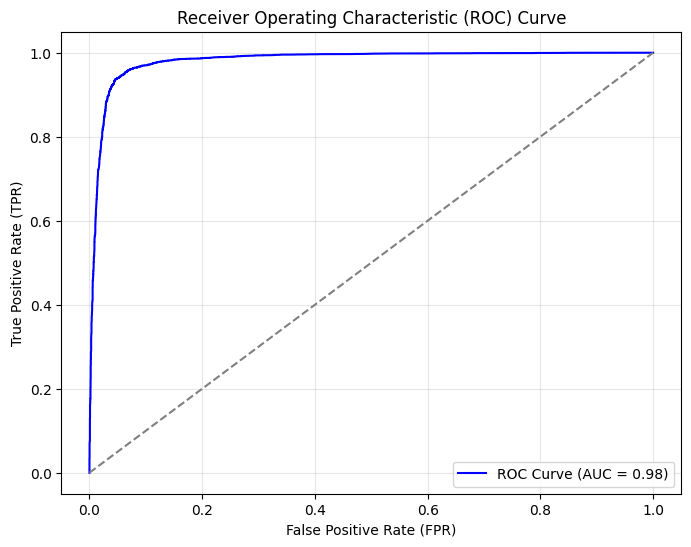

In [95]:
# Plotting the ROC Curve
print("\nGenerating ROC Curve...")
# Get predictions for the test set
predictions = trainer.predict(test_data)

# Calculate probabilities for the positive class (logits -> probabilities)
probs = np.exp(predictions.predictions) / np.exp(predictions.predictions).sum(axis=-1, keepdims=True)
positive_probs = probs[:, 1]  # Probabilities for the positive class

# Get the true labels
labels = predictions.label_ids

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(labels, positive_probs)  # False positive rate and true positive rate
roc_auc = auc(fpr, tpr)  

# Plot the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

Save and Load Model

In [96]:
# Save the complete model (including architecture and weights)
def save_model(model, path):
    torch.save(model, path)  
    print(f"Model saved to {path}")

In [97]:
# Function to load the model
def load_model(path, device='cpu'):
    model = torch.load(path, map_location=device)
    model.to(device)  
    print(f"Model loaded from {path}")
    return model

In [98]:
# Save path
save_path = r"C:\Users\Lucas\Desktop\Analisis de sentimientos\Models\sentiment analyser.pt"
save_model(model, save_path)

# Load the model again to verify
model_loaded = load_model(save_path, device='cuda' if torch.cuda.is_available() else 'cpu')

# Verify if the model was loaded correctly
print(model_loaded)

Model saved to C:\Users\Lucas\Desktop\Analisis de sentimientos\Models\sentiment analyser.pt


C:\Users\Lucas\AppData\Local\Temp\ipykernel_9476\3360268112.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(path, map_location=device)


Model loaded from C:\Users\Lucas\Desktop\Analisis de sentimientos\Models\sentiment analyser.pt
DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, eleme